---
layout: post
title:  "Logistic Regression - Introduction, Assumptions, and Pitfalls"
short_title: "An Introduction to Logistic Regression"
desc: "A beginners introduction to logistic regression in python."
long_desc: "A Python based introduction to Logistic Regression, covering the concepts, implementation, underlying assumptions and some of the pitfalls of the model."
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/logistic"

math: true
---

In this small write up, we'll cover logistic functions, probabilities vs odds, logit functions, and how to perform logistic regression in Python.

Logistic regression is a method of calculating the probability that an event will pass or fail. That is, we utilise it for dichotomous results - 0 and 1, pass or fail. Is this patient going to survive or not? Is this email spam or not? This is specifically called **binary logistic regression**, and is important to note because we can do logistic regression in other contexts.

## The background math

As the name implies, it is based off the logistic function. Often when someone says a sigmoid function, they are referring to a logistic sigmoid, which is also what we are referring to. A logistic sigmoid function has the following form:

$$ f(x) = \frac{1}{1 + e^{-x}} $$ 

and looks like this:

In [154]:
# Remove
from base import *
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.1
plt.rcParams['image.cmap'] = 'RdYlGn_r'
plt.rcParams['lines.markersize'] = 4
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#4CAF50', '#03A9F4', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

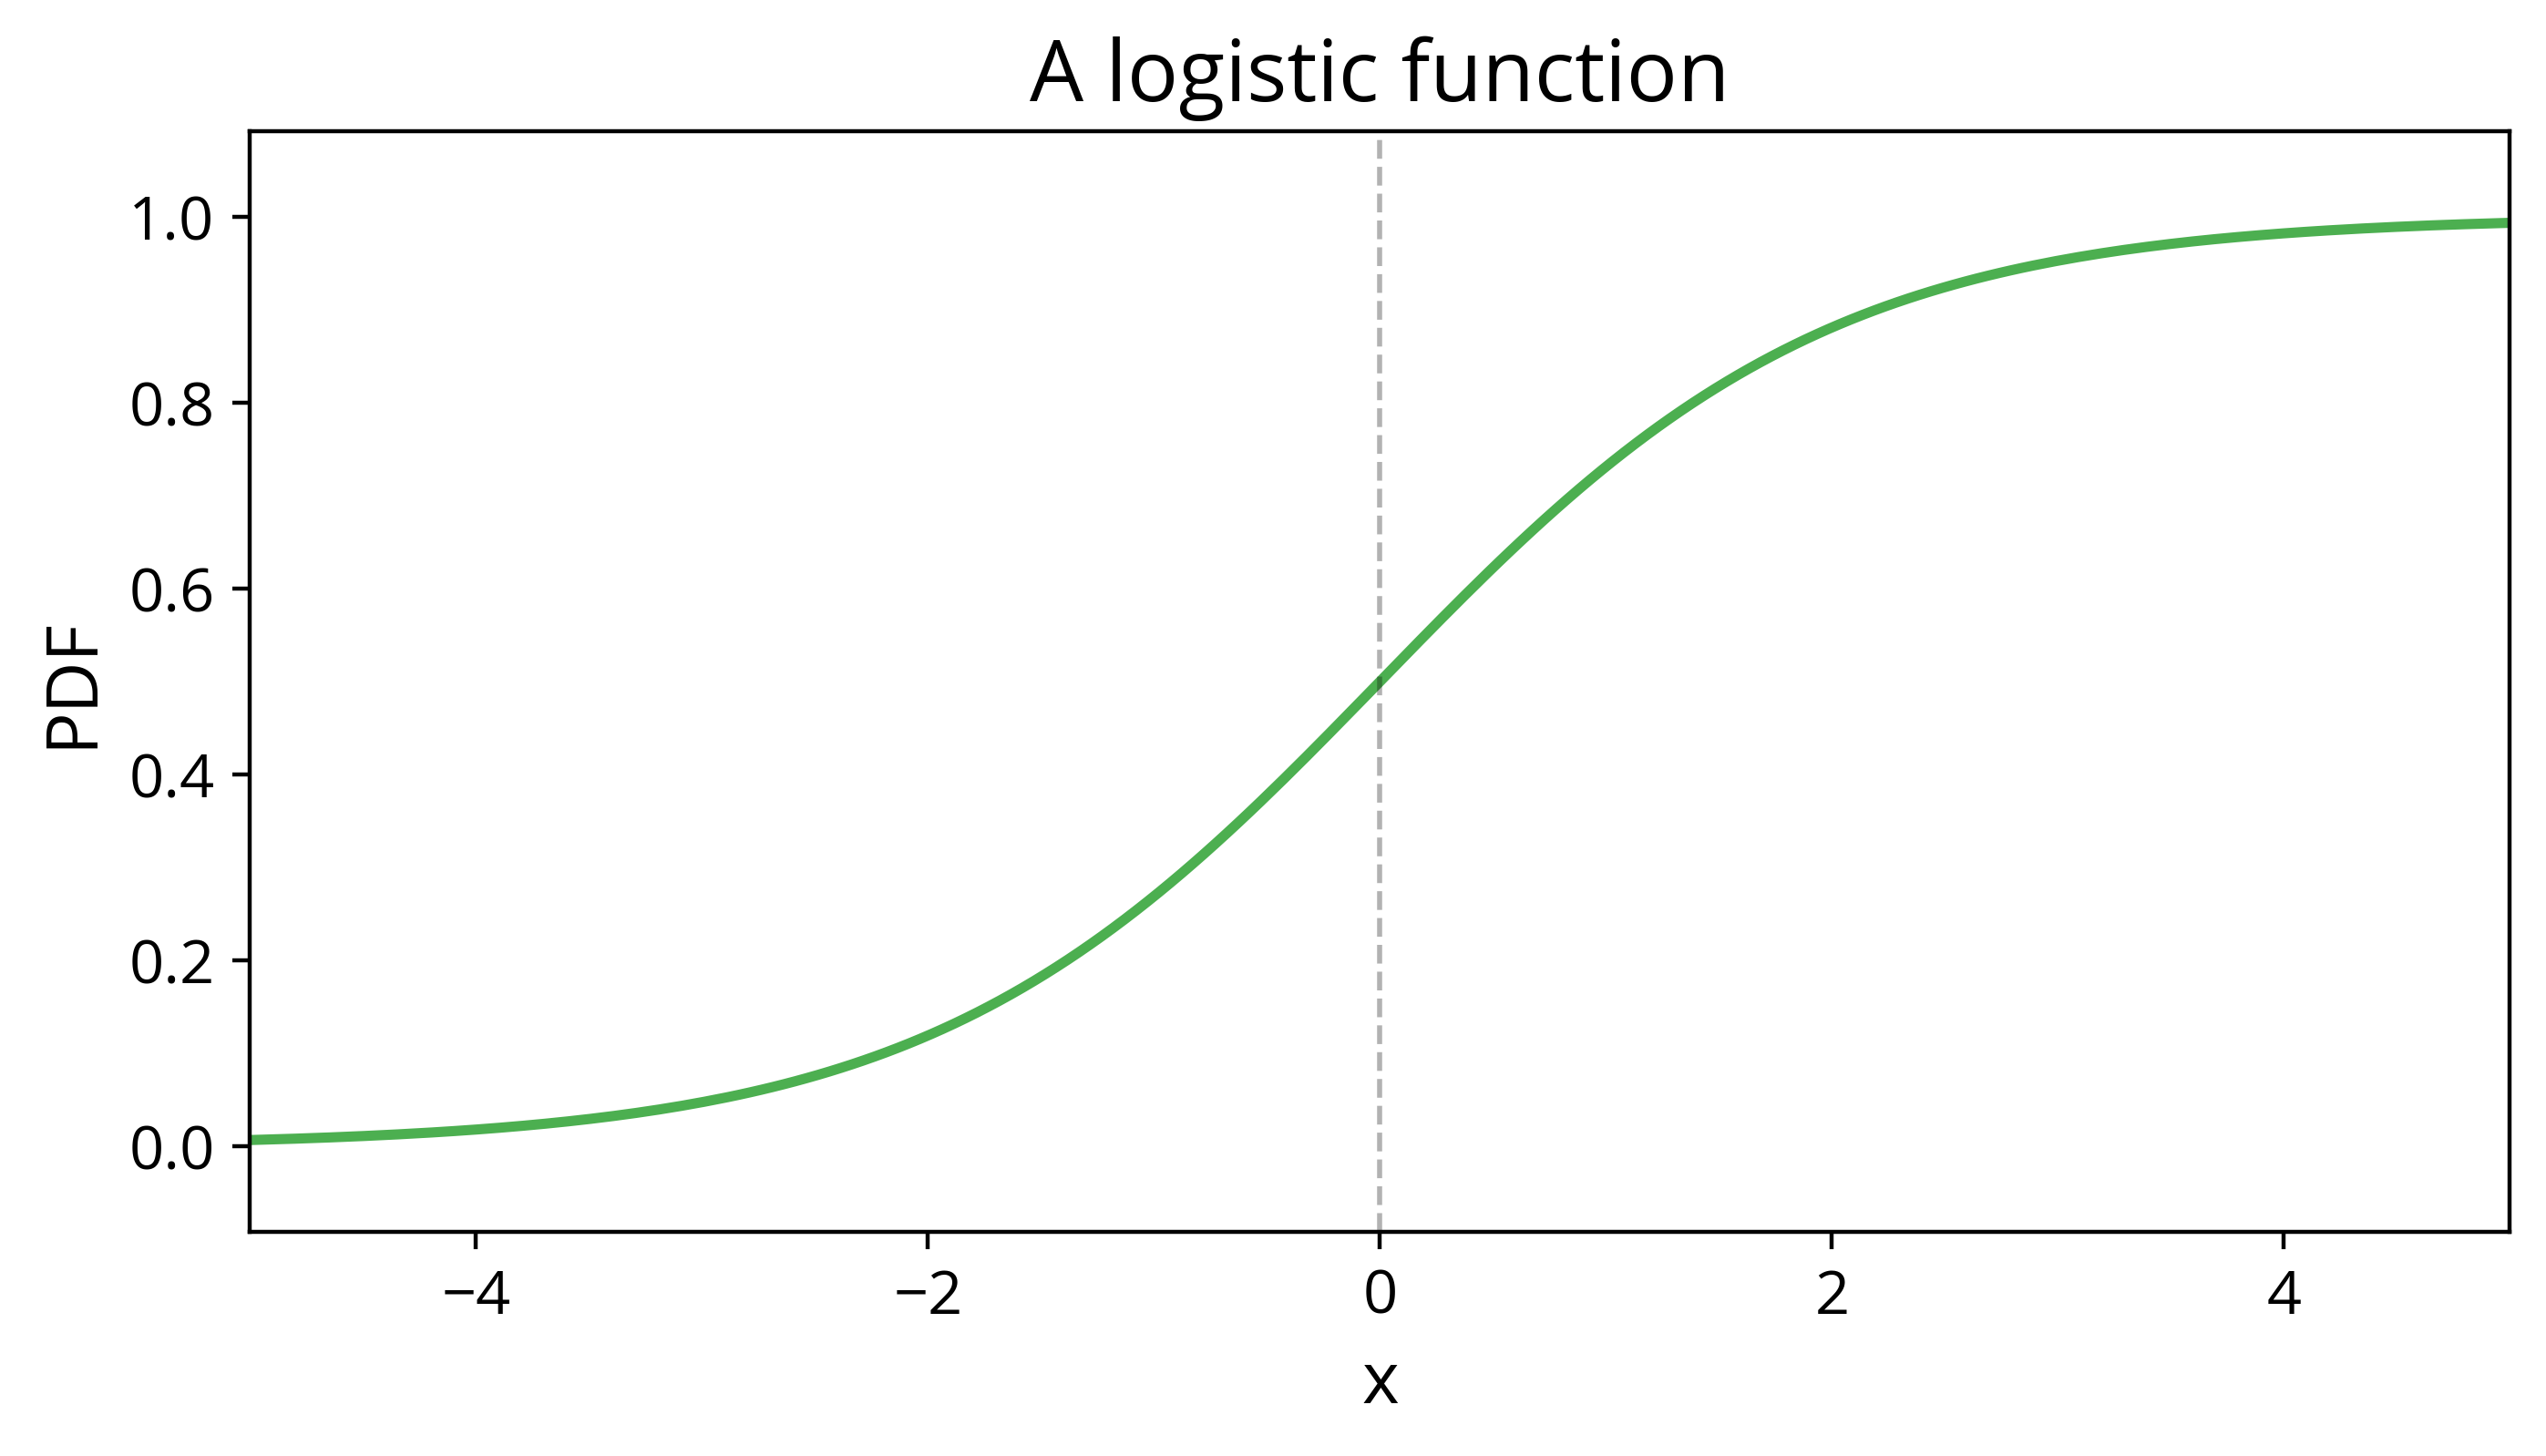

In [148]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.linspace(-5, 5, 200)
ps = 1 / (1 + np.exp(-xs))

fig, ax = plt.subplots()
ax.plot(xs, ps)
ax.axvline(0, c="k", ls="--", alpha=0.3, lw=1)
ax.set_title("A logistic function"), ax.set_xlabel("x"), ax.set_ylabel("PDF");

So this raises the question - now that we have some function which goes from 0 to 1... how do we actually use it? 

Let's create a simple example with some data, something super easy to understand. How about the probability that an egg breaks when dropped from some distance. Our binary variable is whether the egg broke, and the single input is the height it was dropped. We can, of course, have multiple inputs.

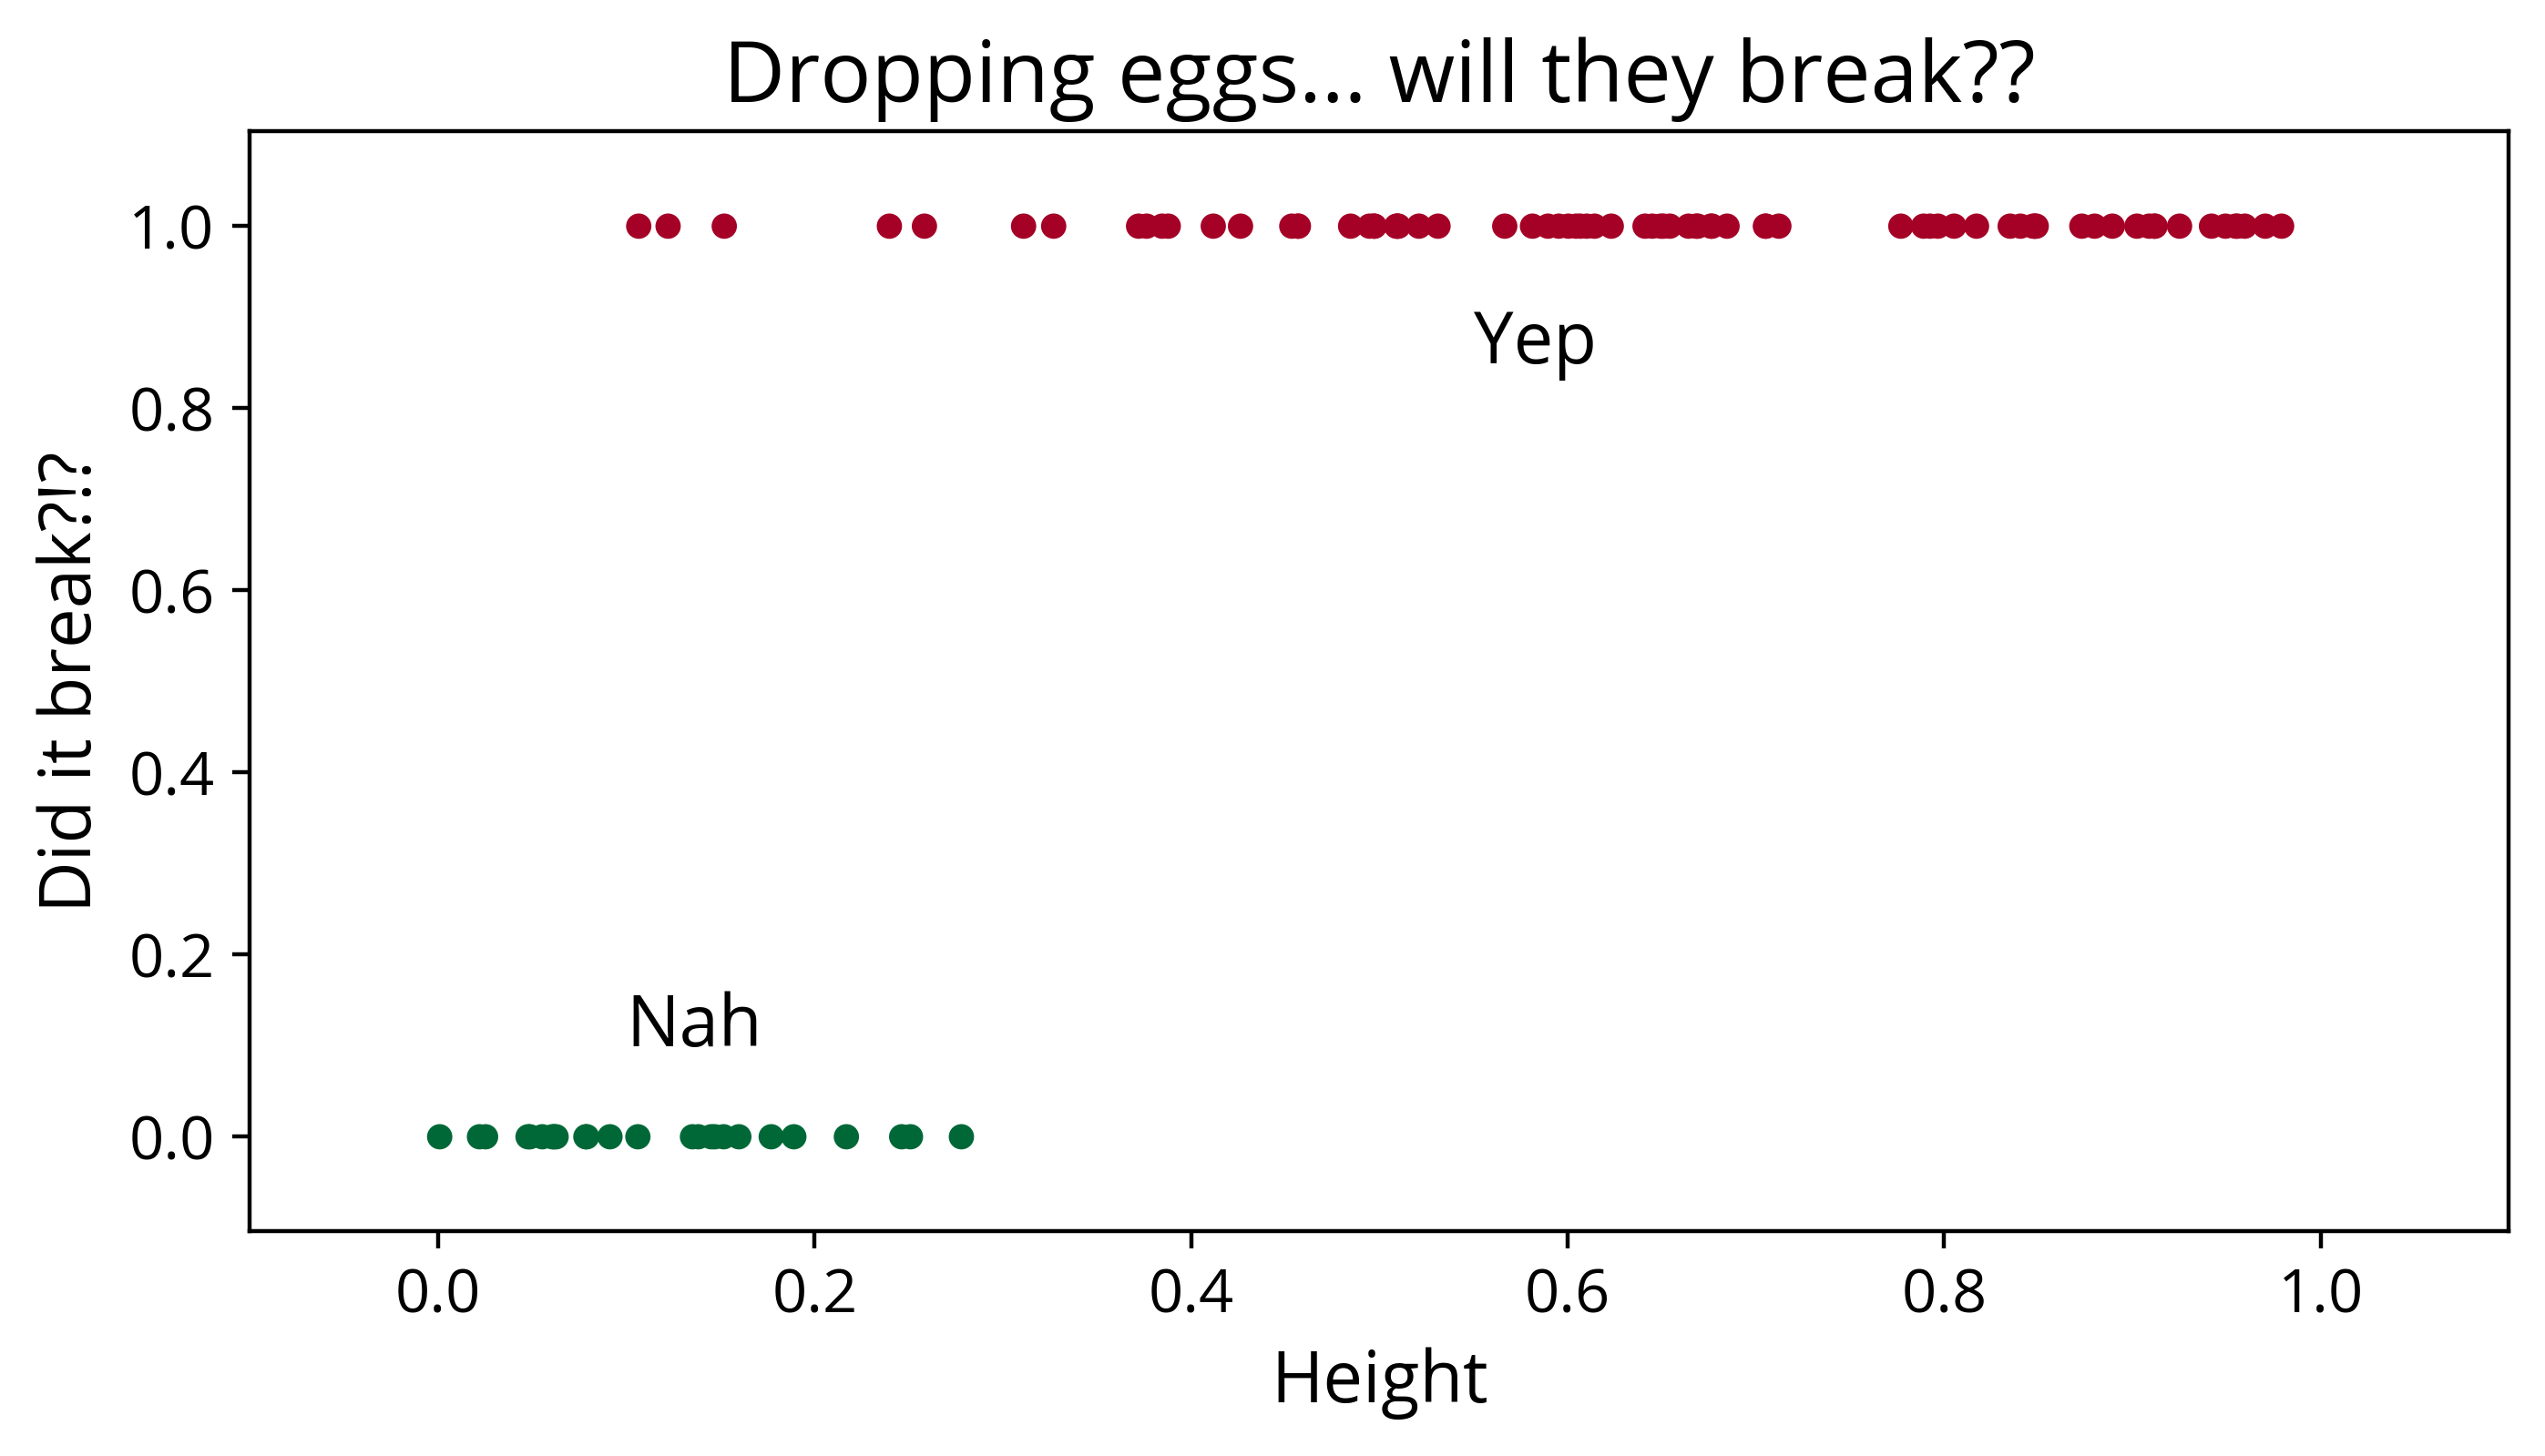

In [176]:
# Using a sigmiod to generate data for a sigmoid example
# How uninspired!
height = np.random.random(100)
broke = 1/(1+np.exp(-20*height+5)) > np.random.random(100)

plt.scatter(height, broke, c=broke)
plt.xlabel("Height"), plt.ylabel("Did it break?!?")
plt.annotate("Yep", (0.55, 0.85)), plt.annotate("Nah", (0.1, 0.1))
plt.title("Dropping eggs... will they break??")
plt.xlim(-0.1, 1.1); ###REMOVE

What logistic regression is going to do, is get us $P(\text{egg broke}\ \|\ \text{height it was dropped})$. The separator there is read in English as "given that", if the syntax is new. The nomenclature generally denotes the output at $Y$ and the input as $X$, so this would be $P(Y=1\|X)$. We call these sort of models that give the output condition on the input **"discriminative models"**.

There is a small subtlety here. The input $X$ is not just the height - we want logistic regression to handle multiple inputs combined in different ways (and a bias), which means we define the input $X$ as
$$ X = \beta_0 + \beta_1 X_1 + \beta_2 X_2 ... $$

where we fit for the $\beta_i$ parameters, and $X_1$ is our first feature (aka variable/column, for us this is height), and $X_2$ the second feature (which we dont have in our example).

<div class="aside" markdown="1">

Before going further, I should pause here and clarify the difference between probability and a probability ratio. If you open up random pages on logistic regression, sometimes you will see:

$$ f(x) = \frac{1}{1 + e^{-X}} \quad \text{or}\quad  f(x) = \frac{e^{-X}}{1 + e^{-X}} $$

The former is the probability (and is a *logistic* function), the latter is the probability ratio (better known as the odds, or odds ratio, and this one is called a *logit transformation*), and you can derive the ratio by simply rearranging

$$ \frac{P(Y=1|X)}{1 - P(Y=1|X)}. $$

So if we have $P(Y=1\|X)=0.9$, thats an odds ratio of $0.9/0.1 = 9$. As the probability goes from $0$ to $1$, the odds will go from $0$ to $\infty$, which means the **log odds** will go from $-\infty$ to $\infty$. **For logistic regression, we normally optimise the log odds.**

Why? A few reasons. Firstly, numerically its easier to not work with bounded functions, and having infinite range is great. More importantly, working in log odds allows us to better understand the impact of any specific $X_i$ (column) in our model. For example, if your model is predicting $p=0.5$ and you perturb $X_1$ slightly, you might get $p=0.509$. This is a negligible change. But if you your model is giving you $p=0.99$ and you perturb $X_1$ and get $p=0.999$, thats not negligible, your model is 10 times as confident! Working in odds helps us get around this potential confounder. 

So what we normally do is **optimise using logit transformation**, and **report probabilities based on the logistic function**.

</div>

Back on track, lets see what an abitrary fit to a logistic function would look like:


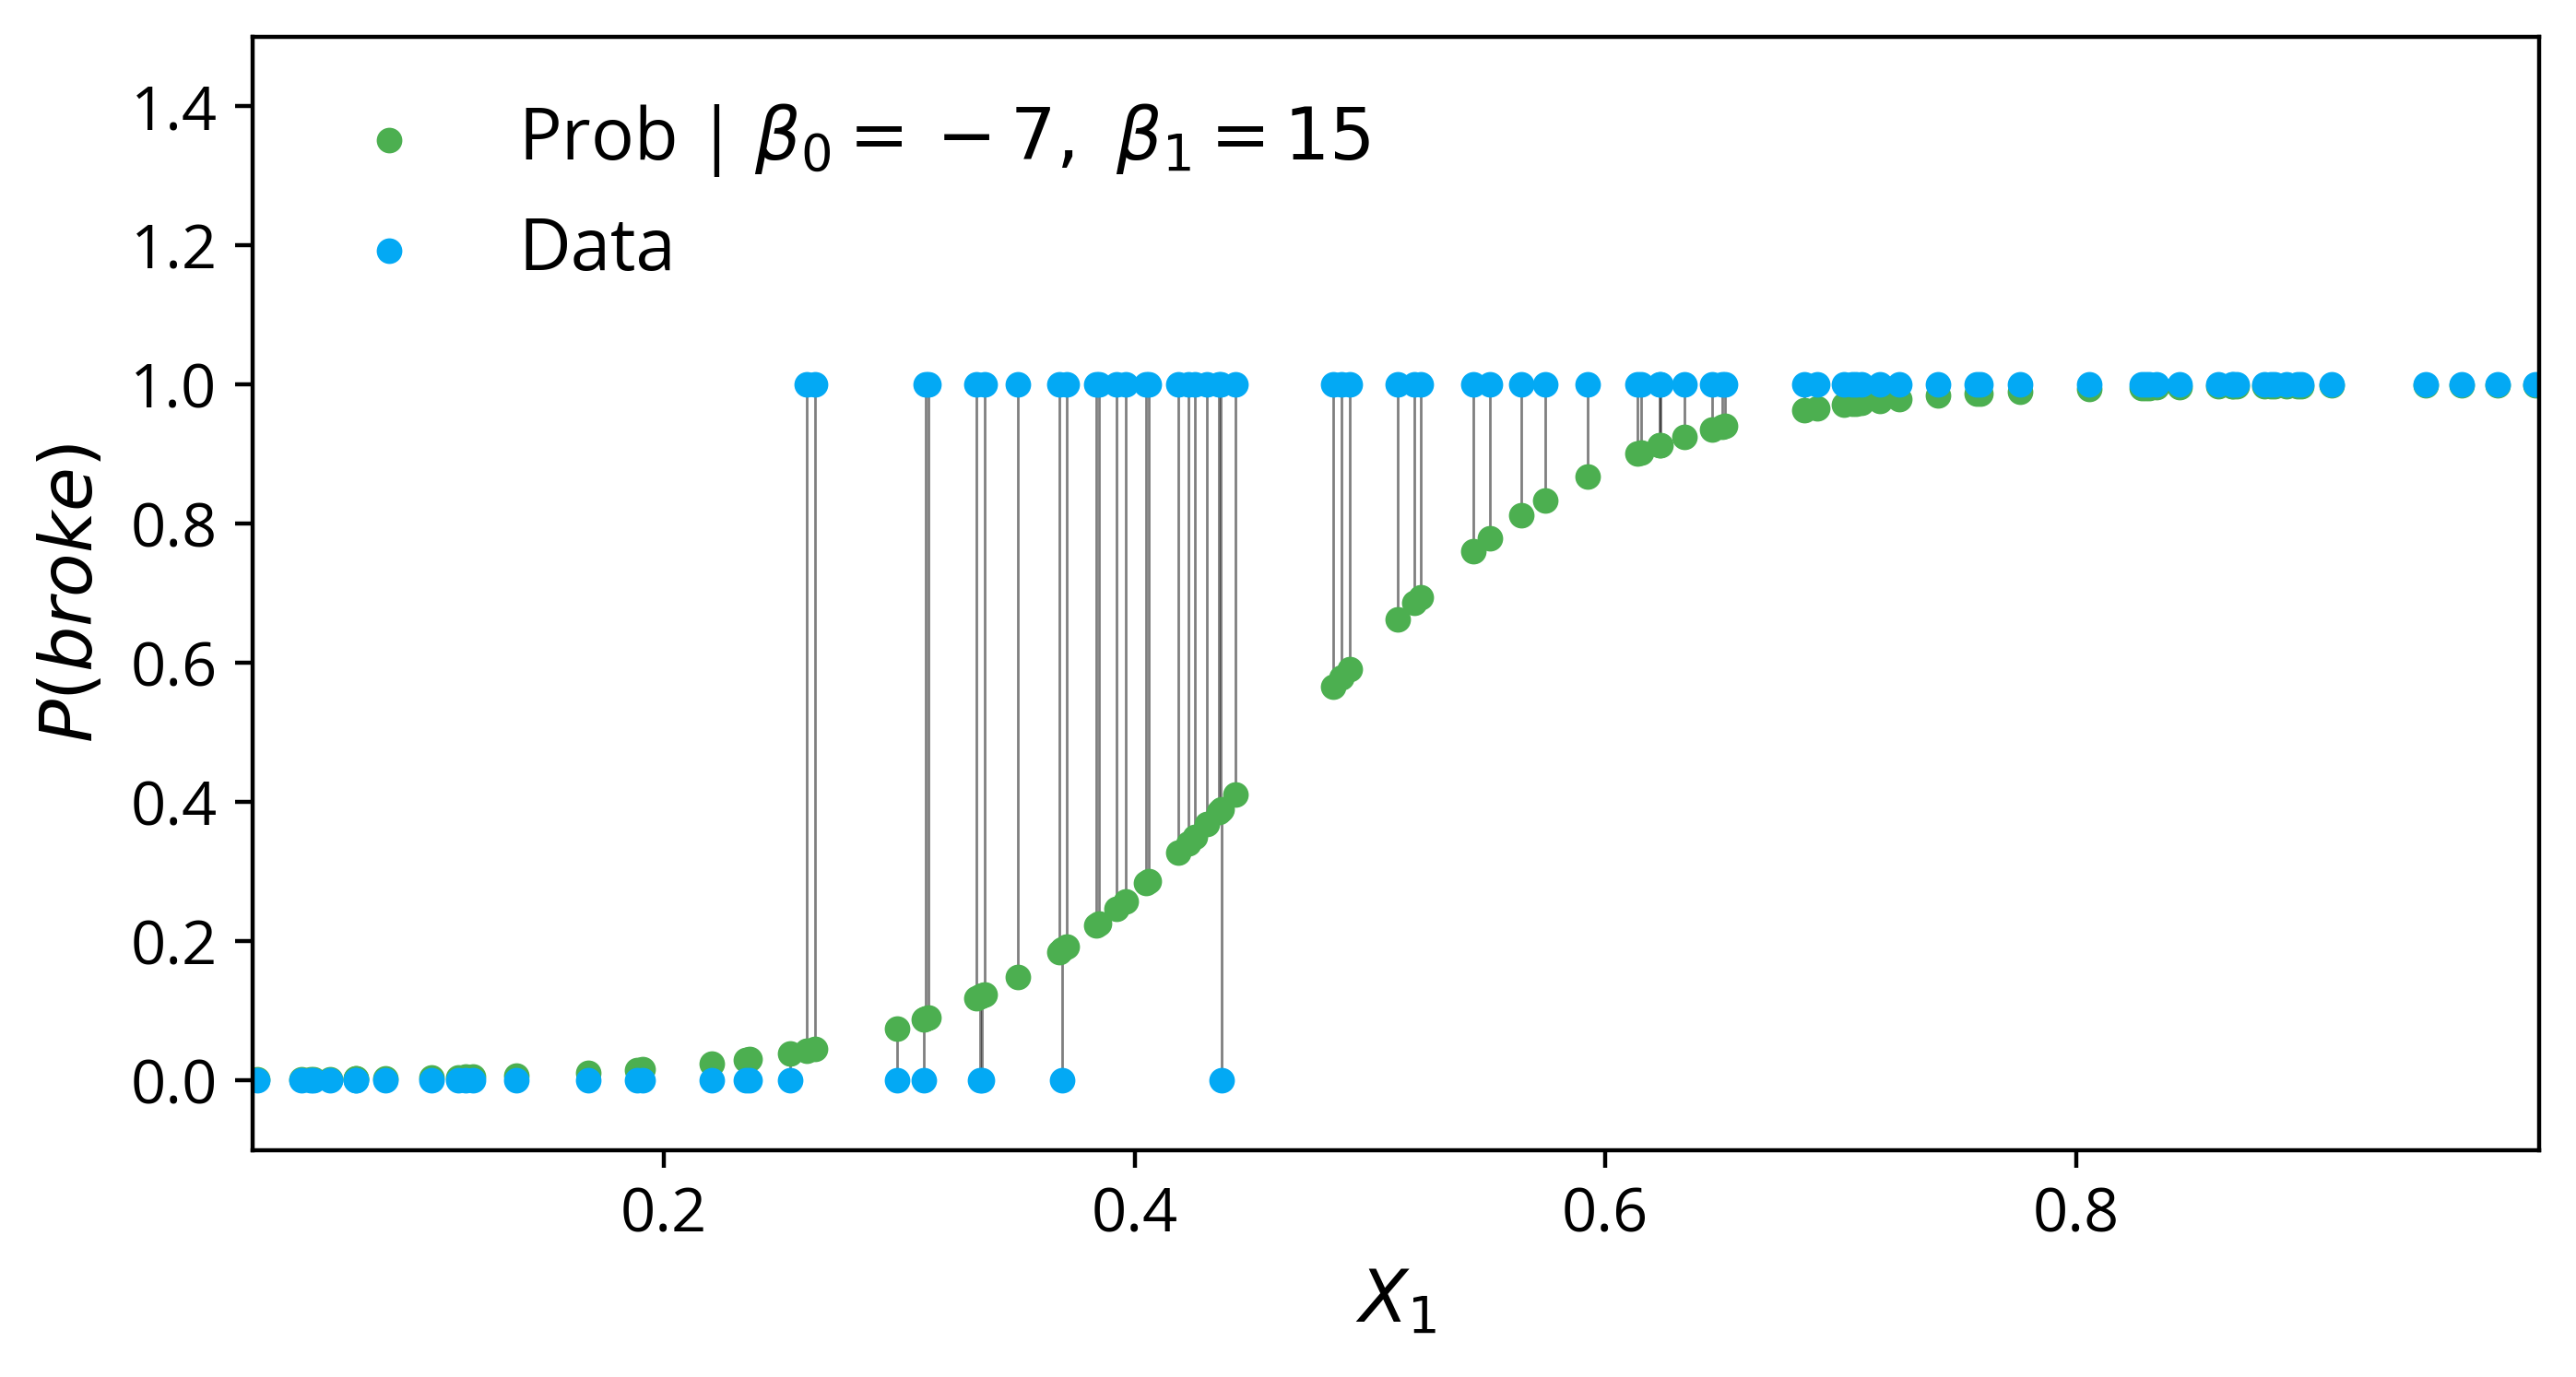

In [145]:
def logistic(x_1, beta_0, beta_1):
    X = beta_0 + beta_1 * x_1
    return 1 / (1 + np.exp(-X))

b0, b1 = -7, 15

# Get some probabilities for arbitrary params
probs = logistic(height, b0, b1)

plt.scatter(height, probs, label=f"Prob | $\\beta_0={b0},\\ \\beta_1={b1}$")
plt.scatter(height, broke, label="Data")
for a, b, c in zip(height, probs, broke): ###REMOVE
    plt.plot([a, a], [b, c], color="k", ls="-", zorder=0, lw=0.5, alpha=0.5)  ###REMOVE
plt.legend(loc=2), plt.xlabel("$X_1$"), plt.ylabel(r"$P(broke)$")
plt.ylim(-0.1, 1.5); ###REMOVE

Notice that we are *comparing probabilities to binary outcomes here*. If we wanted outcomes, we'd add some threshold (like 0.5) that we would cut on. Over 0.5 and its a success, under 0.5 and its a failure. We'll see this down below.

## Using sklearn

At this point, we now have - like any other form of regression - predictions vs data, and we could optimise the parameters ($\beta_i$) such that we fit the logistic as well as we can. Here is how you would do that using `sklearn`:

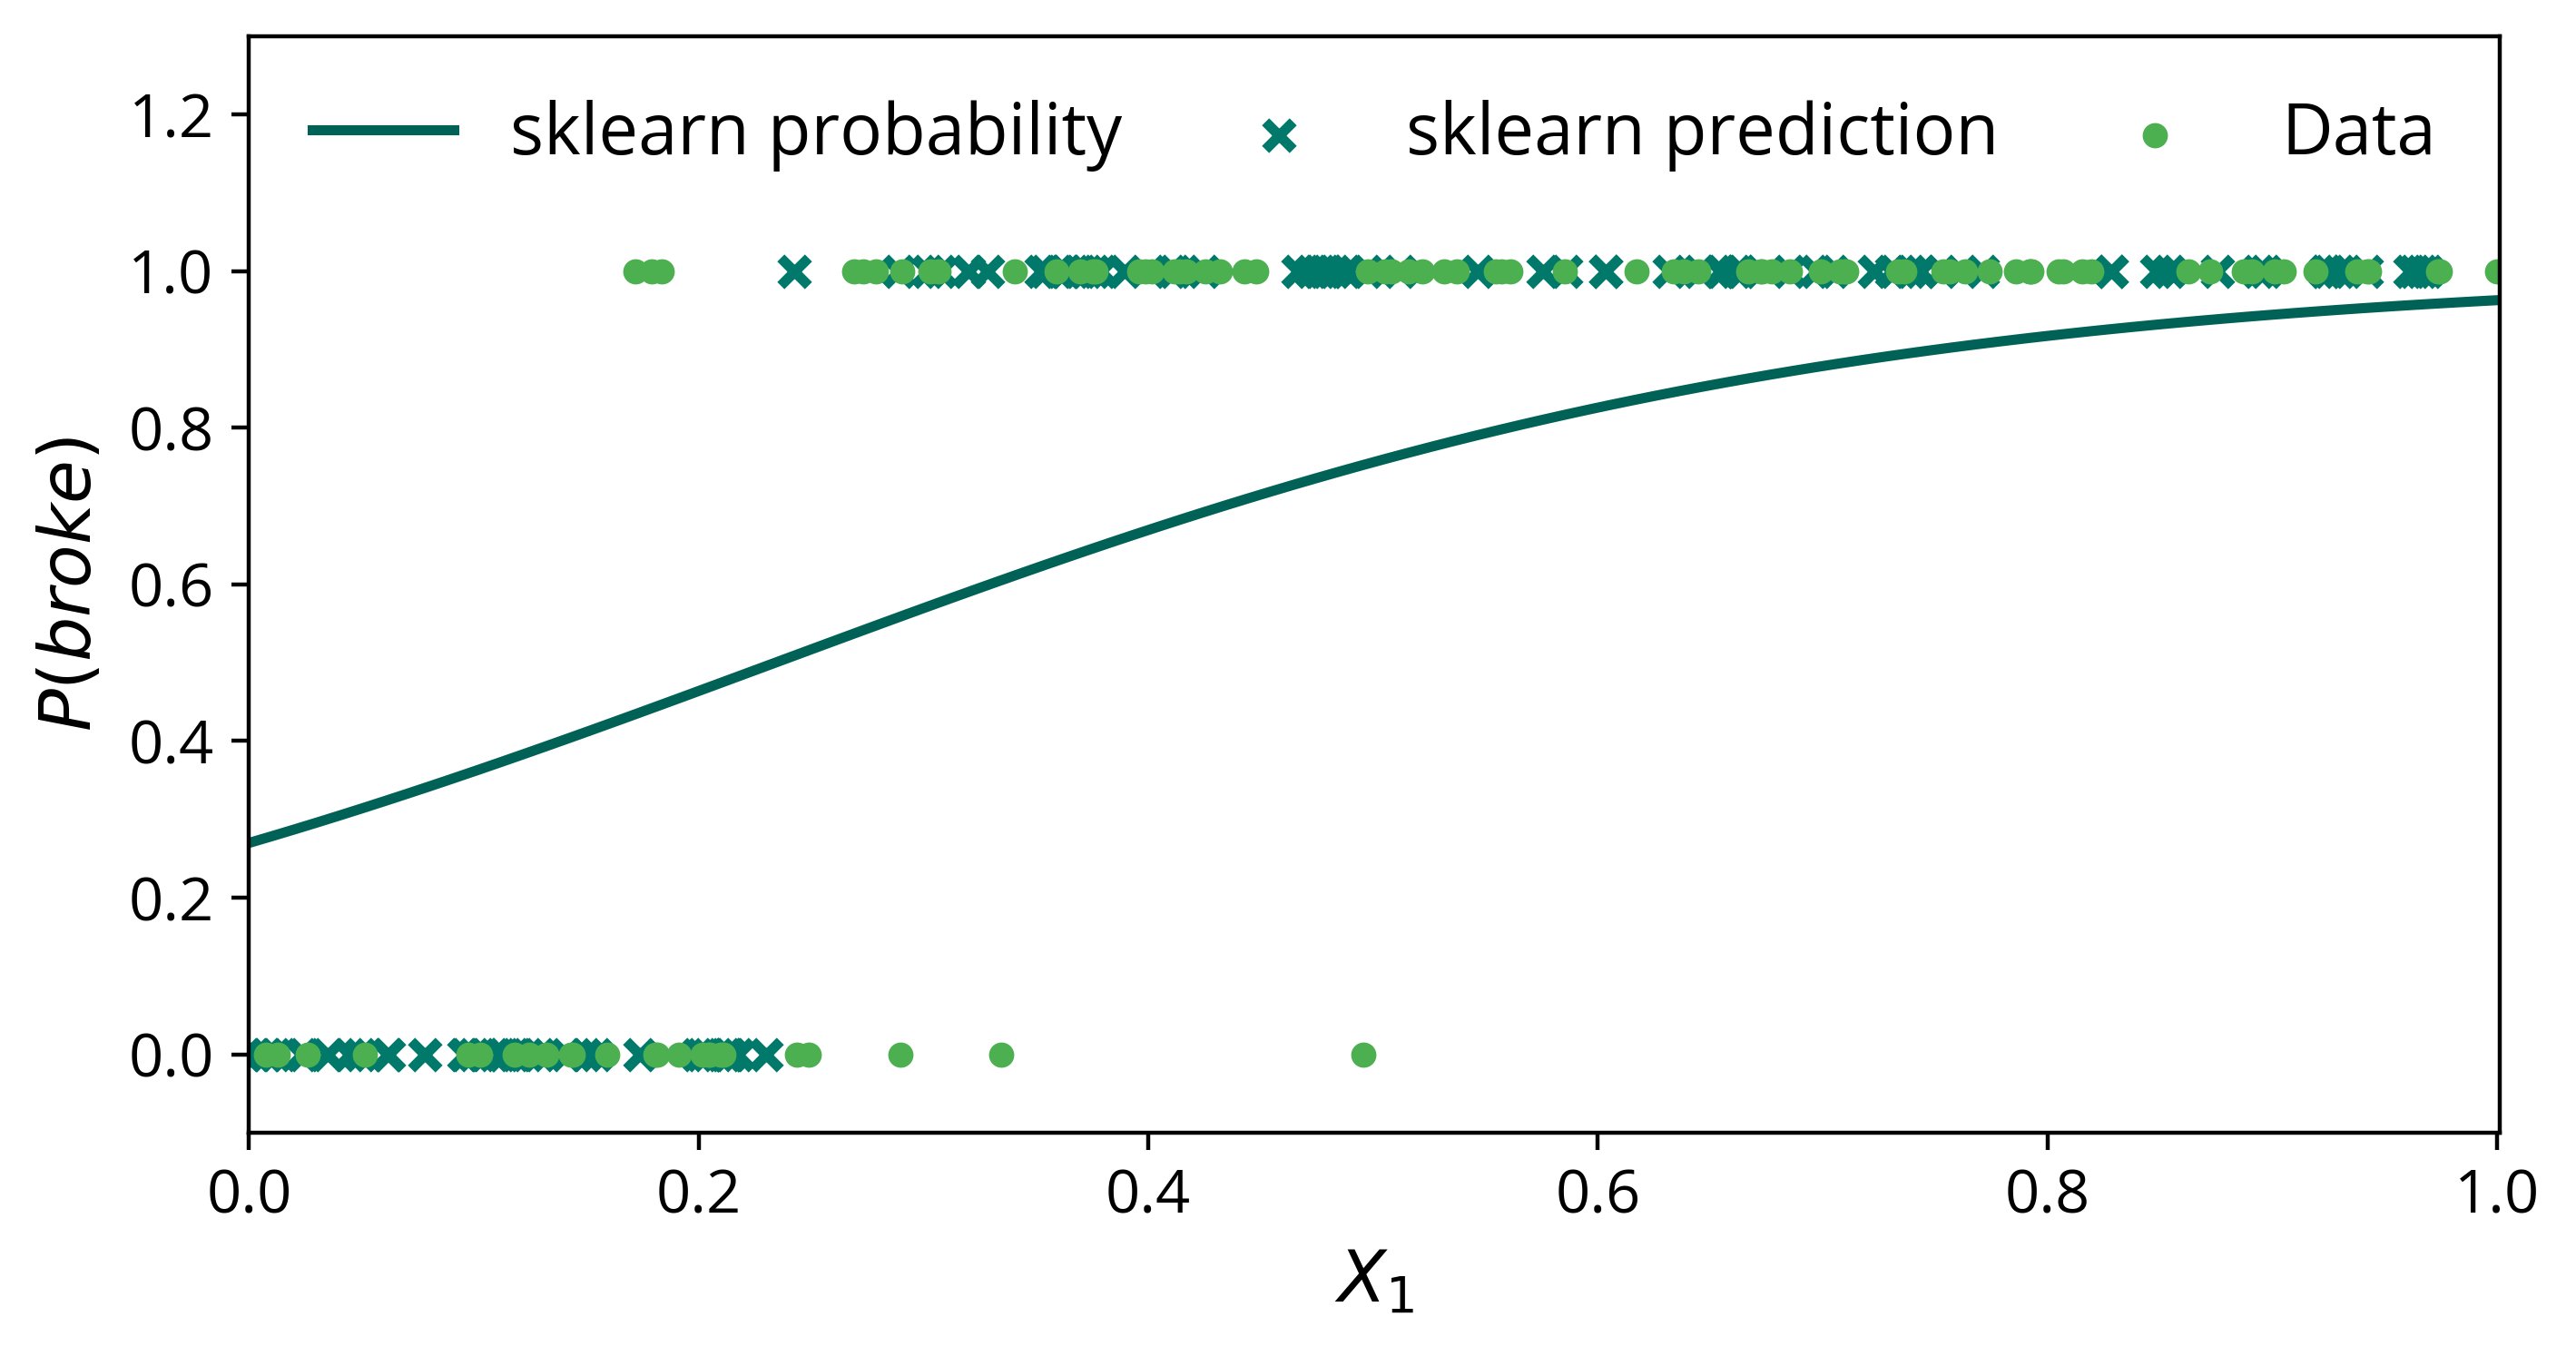

In [171]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)

# Fit by passing in all features, and the outcome variable
# The [:, None] just makes it a 2D array, not 1D
model.fit(height[:, None], broke)

# Predict 0 or 1 on our inputs to check
pred_binary = model.predict(height[:, None])

# Get prob for a smooth range of heights
xs = np.linspace(0, 1, 100)
pred_prob = model.predict_proba(xs[:, None])

# Plotting code
plt.scatter(height, pred_binary, label=f"sklearn prediction", s=30, marker='x', zorder=0, c="#00796B")
plt.scatter(X_1, Y, label="Data")
plt.plot(xs, pred_prob[:, 1], label="sklearn probability", c="#006156", zorder=-1)
plt.legend(loc=2, mode="expand", ncol=3)
plt.xlabel("$X_1$"), plt.ylabel(r"$P(broke)$");
plt.ylim(-0.1, 1.3); ###REMOVE

Now if you're looking at the probability function and thinking "this doesnt look like a sigmoid at all", you're entirely right. Welcome to the world of **regularization**. For small data like we have, the default L2 regularisation is going to ensure that our $\beta$ values stay pretty low.

If we want to see what happens without the penalty, we can turn it off, but note that in general, its good practise to keep it on because it helps with the generalisation of our models.

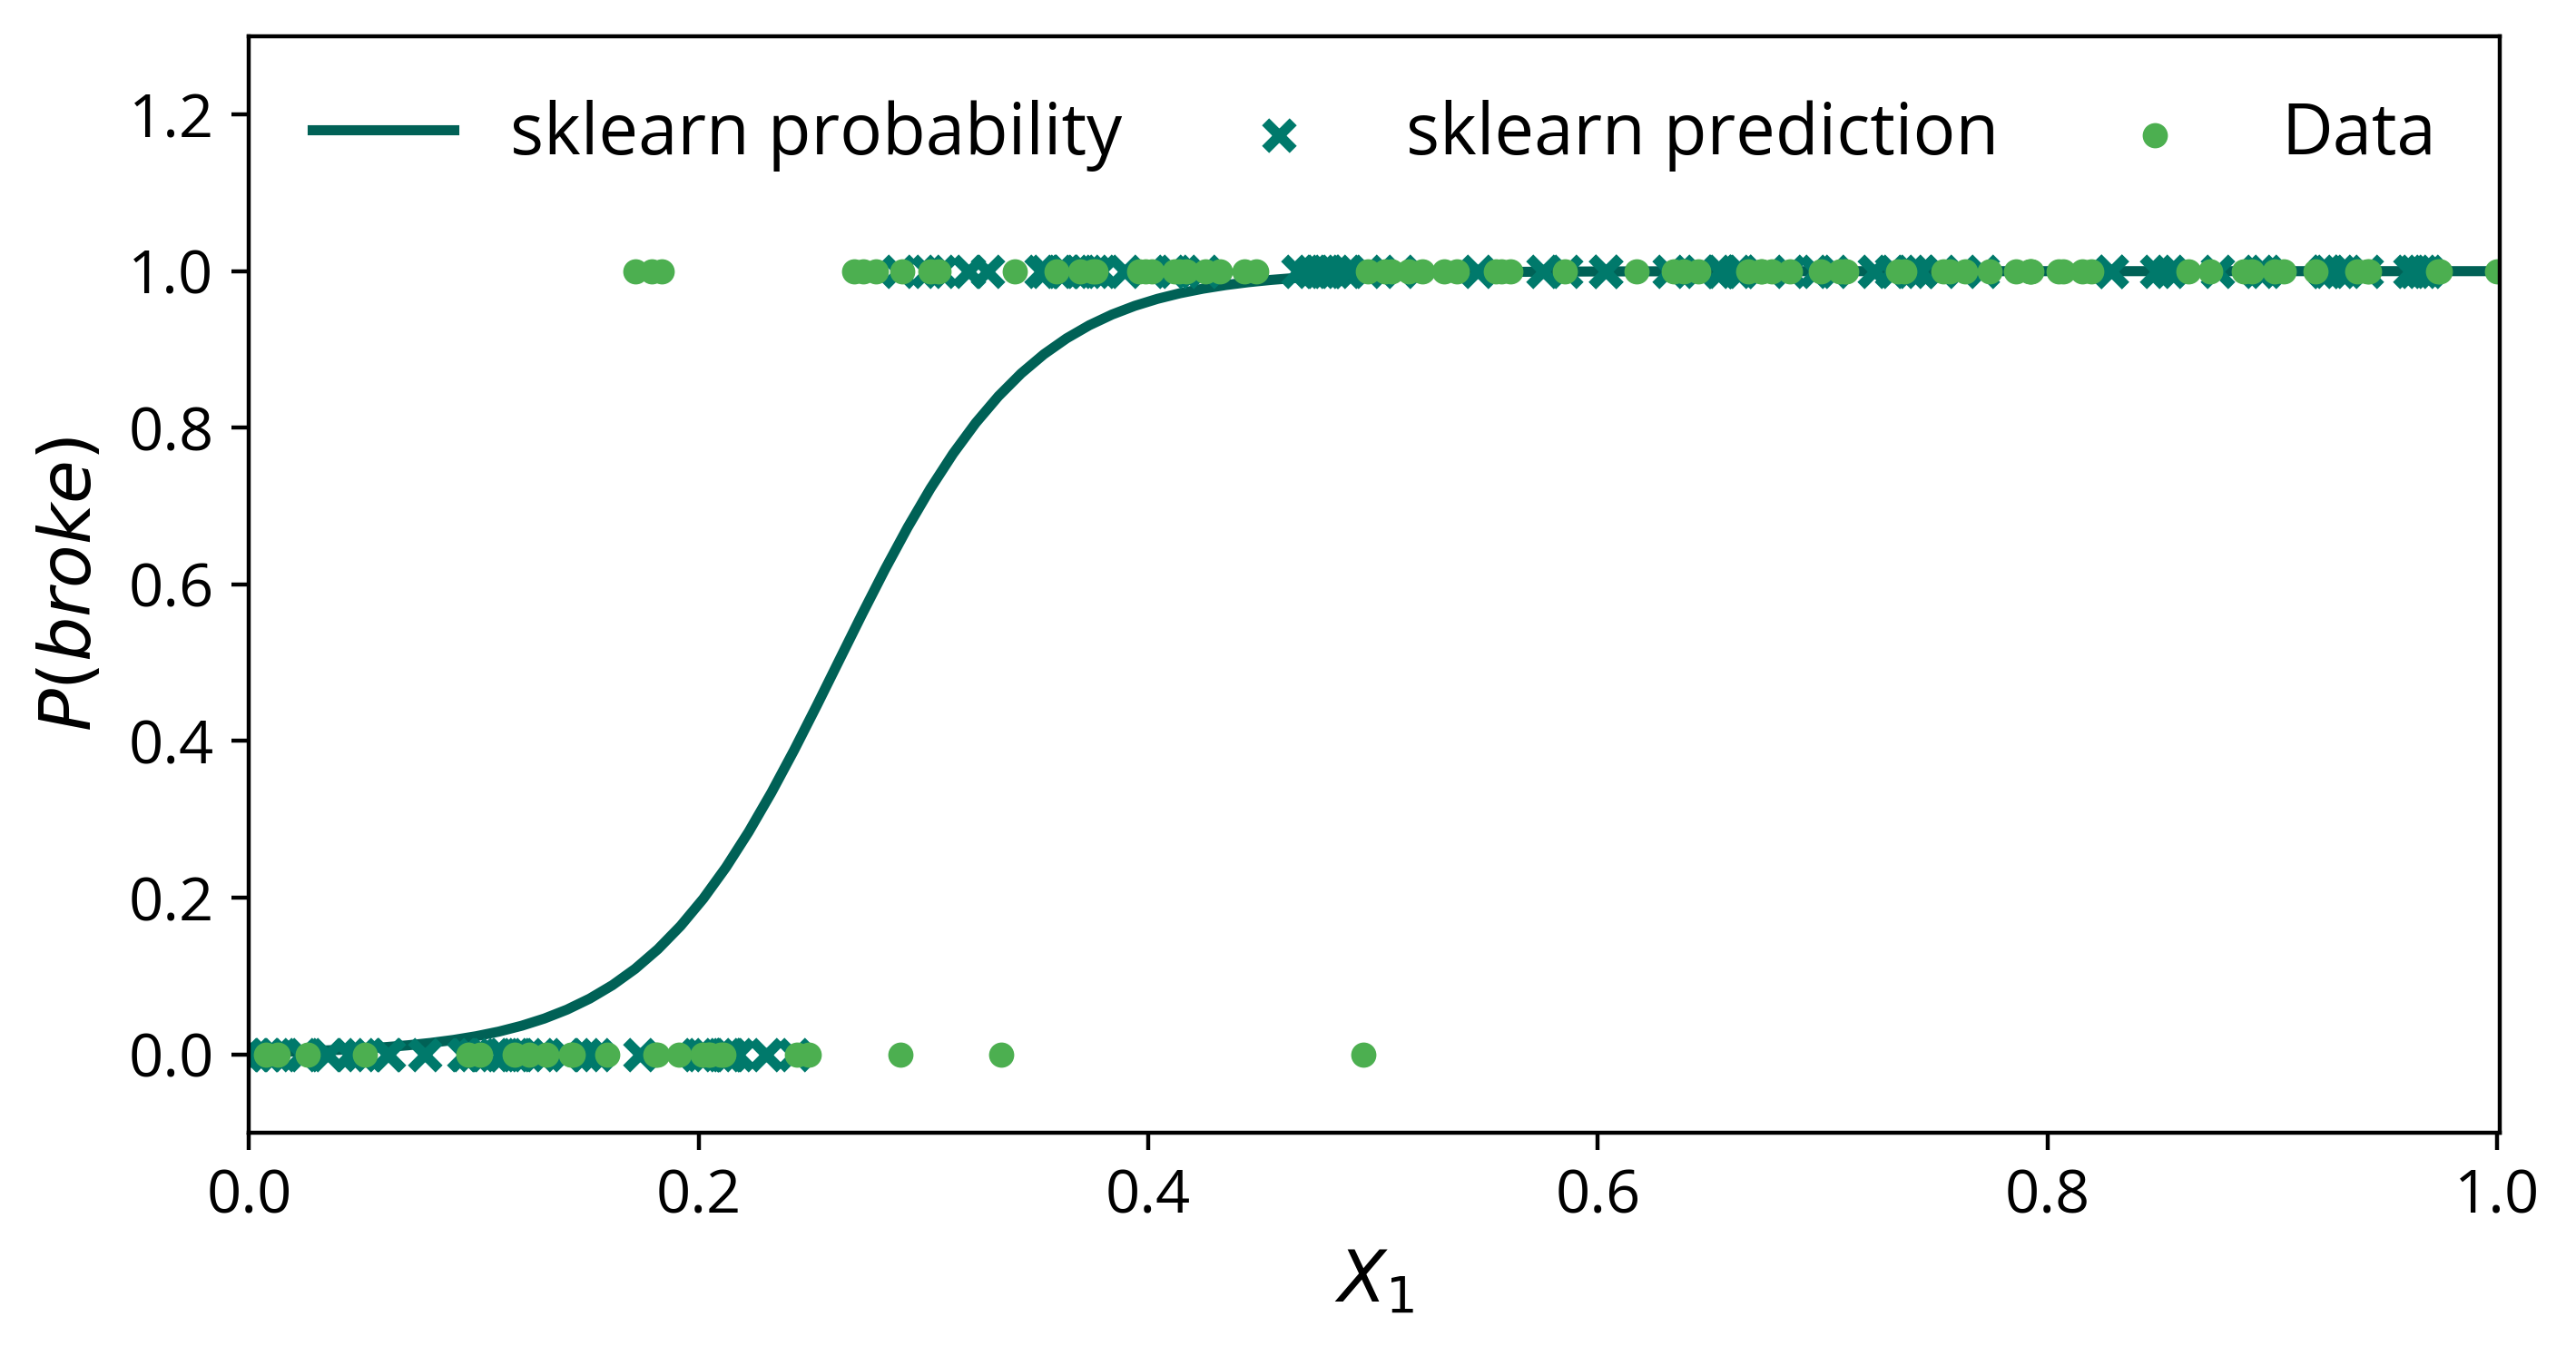

In [174]:
model = LogisticRegression(random_state=0, penalty="none")
model.fit(height[:, None], broke)
pred_binary = model.predict(height[:, None])
pred_prob = model.predict_proba(xs[:, None])
plt.scatter(height, pred_binary, label=f"sklearn prediction", s=30, marker='x', zorder=0, c="#00796B")
plt.scatter(X_1, Y, label="Data")
plt.plot(xs, pred_prob[:, 1], label="sklearn probability", c="#006156", zorder=-1)
plt.legend(loc=2, mode="expand", ncol=3)
plt.xlabel("$X_1$"), plt.ylabel(r"$P(broke)$");
plt.ylim(-0.1, 1.3); ###REMOVE

!!!main

And you can now see that its a much better fit to the data (in terms of probability, not necessarily in terms of predictions). Instead of turning it off, we can also modify the `C` value which controls the regularization strength. The larger you set `C`, the less regularization you get.

## Assumptions that go into logistic regression

Its time to get our hands dirty and talk about assumptions. First, you can incorporate uncertainty into `sklearns` implementation of LogisticRegression by changing the sample weights of each sample (if one sample has twice as much uncertainty as another, it has half the weight), which can be passed in when you fit the model. This is a choice you make, not one the regression makes. Furthermore, the regression does not assume:

* **Linearity**: You do not need to have a linear relationship between dependent and independent variables (output and input).
* **Normality**: Your uncertainty does not have to be normally distribution.
* **Homoscedasticity**: Is not required. Without the jargon: you can have different amounts of uncertainty on different features.

That said, there are stil some assumptions to be aware of:

* **Observations are independent**: Each egg drop is brand new.
* **Features are directional**: Logisitc regression might give odd answers if the impact of features are one unidirectional. For example, mortality and age have peaks at the very young and very old, so using age to predict mortality not give you good results because you have only one $\beta$ value for that column that will only push the result in one direction.
* **No multicollinearity**: Whilst logistic regression can handle correlated variables, keep the correlations below 0.9.
* **You have a large sample**: For good results, try to ensure your sample size isn't just a handful of points. A hundred points is a good (and arbitrary) starting point, and you will need more points per feature that you use.

## Summary

If you've made it down to this point, congratulations! To try and briefly summarise everything:

* Binary lostistic regression is used for binary problems.
* The logistic function smoothly transitions from 0 to 1 and gives a probability.
* The logit function is a transformation to get odds from $X$.
* Regularization is good for generalisation, even if it makes things look a bit odd on low number test data.
* The assumptions going into logistic regression are fairly minimal, making it applicable for a variety of problems.

I hope its useful!